In [66]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [3]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/research/data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30,80)
reppu_data.shape

(45792, 30, 80)

In [4]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [5]:
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset>
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon        (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71

In [51]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs
omni_df

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset>
Dimensions:         (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -15.45 -15.47
    BY_GSE          (dt) float64 4.72 4.35 4.61 4.65 ... -2.49 -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 6.24 6.55 6.56 6.89 ... -4.47 -4.47 -4.64 -4.5
    flow_speed      (dt) float64 344.0 344.0 345.0 344.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 12.11 11.44 12.65 12.63 ... 6.22 6.22 5.59 5.34
    tilt_angle      (dt) float64 0.253 0.2497 0.2465 ... 0.1837 0.1769 0.1735

In [30]:
reppu_omni_ds_range1 = reppu_omni_ds.sel(dt=slice('2021-12-01', '2022-01-24'))
reppu_omni_ds_range2 = reppu_omni_ds.sel(dt=slice('2022-06-10', '2022-07-31'))
reppu_omni_ds_combined = xr.concat([reppu_omni_ds_range1, reppu_omni_ds_range2], dim='dt')
reppu_omni_ds = reppu_omni_ds_combined.sortby('dt')
reppu_omni_ds

<xarray.Dataset>
Dimensions:         (dt: 30816, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2021-12-01 ... 2022-07-31T23:55:00
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 1.71 1.487 1.264 ... -22.67 -22.71
    BY_GSE          (dt) float64 9.2 7.67 6.28 3.55 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 0.85 3.45 -1.59 0.46 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 443.0 444.0 454.0 460.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 7.8 7.93 9.79 10.19 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 -0.4314 -0.4347 -0.4381 ... 0.2778 0.2744 0.271

In [52]:
#train_slice = slice(0, 15840) #55days * 288 = 15840
#test_slice = slice(15840, None) #15 days * 288 = 4320

#train_slice = slice(0, 11520) #40days * 288 = 11520
#test_slice = slice(11520, None) #10 days * 288 = 2880 

# Define the slice ranges for train and test data
train_slice = slice(0, 36576) #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None) # 9216 / 24 / 12 = 32 days = 20% of the data

ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80)
#y_train = np.mean(y_train, axis=1)

X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80)
#y_test = np.mean(y_test, axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36576, 5), (36576, 2400), (9216, 5), (9216, 2400))

In [53]:
# Normalizing the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [54]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [56]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Remove extra dimensions from output
        out = self.fc(out[:, -1, :].squeeze())  # Squeeze the output
        return out


In [88]:
def dummy_slider():
    x = np.arange(0, 288)
    seq_len = 12
    slider = 6

    for i in range(0, len(x) - seq_len + 1, slider):
        inputs = x[i:i + seq_len]
        targets = x[i + seq_len - 1]
     
        print(f'inputs: {inputs}, targets: {targets}')

dummy_slider()

inputs: [ 0  1  2  3  4  5  6  7  8  9 10 11], targets: 11
inputs: [ 6  7  8  9 10 11 12 13 14 15 16 17], targets: 17
inputs: [12 13 14 15 16 17 18 19 20 21 22 23], targets: 23
inputs: [18 19 20 21 22 23 24 25 26 27 28 29], targets: 29
inputs: [24 25 26 27 28 29 30 31 32 33 34 35], targets: 35
inputs: [30 31 32 33 34 35 36 37 38 39 40 41], targets: 41
inputs: [36 37 38 39 40 41 42 43 44 45 46 47], targets: 47
inputs: [42 43 44 45 46 47 48 49 50 51 52 53], targets: 53
inputs: [48 49 50 51 52 53 54 55 56 57 58 59], targets: 59
inputs: [54 55 56 57 58 59 60 61 62 63 64 65], targets: 65
inputs: [60 61 62 63 64 65 66 67 68 69 70 71], targets: 71
inputs: [66 67 68 69 70 71 72 73 74 75 76 77], targets: 77
inputs: [72 73 74 75 76 77 78 79 80 81 82 83], targets: 83
inputs: [78 79 80 81 82 83 84 85 86 87 88 89], targets: 89
inputs: [84 85 86 87 88 89 90 91 92 93 94 95], targets: 95
inputs: [ 90  91  92  93  94  95  96  97  98  99 100 101], targets: 101
inputs: [ 96  97  98  99 100 101 102 103 10

In [58]:
seq_len = 3
slider = 12

# Instantiate the LSTM model with updated input_size
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
output_size = y_train_tensor.shape[1]
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

num_epochs = 25
for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor) - seq_len + 1, slider):
        inputs = X_train_tensor[i:i + seq_len]
        targets = y_train_tensor[i + seq_len - 1]
        # Forward pass
        outputs = model(inputs.unsqueeze(0)) # Add batch dimension
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    rmse = np.sqrt(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2f}, RMSE: {rmse:.2f} V')


Epoch [1/25], Loss: 44.24, RMSE: 6.65 V
Epoch [2/25], Loss: 49.47, RMSE: 7.03 V
Epoch [3/25], Loss: 20.48, RMSE: 4.53 V
Epoch [4/25], Loss: 16.52, RMSE: 4.06 V
Epoch [5/25], Loss: 10.12, RMSE: 3.18 V
Epoch [6/25], Loss: 7.32, RMSE: 2.71 V
Epoch [7/25], Loss: 21.28, RMSE: 4.61 V
Epoch [8/25], Loss: 12.95, RMSE: 3.60 V
Epoch [9/25], Loss: 4.90, RMSE: 2.21 V
Epoch [10/25], Loss: 5.52, RMSE: 2.35 V
Epoch [11/25], Loss: 24.92, RMSE: 4.99 V
Epoch [12/25], Loss: 23.71, RMSE: 4.87 V
Epoch [13/25], Loss: 21.56, RMSE: 4.64 V
Epoch [14/25], Loss: 29.20, RMSE: 5.40 V
Epoch [15/25], Loss: 33.60, RMSE: 5.80 V
Epoch [16/25], Loss: 31.48, RMSE: 5.61 V
Epoch [17/25], Loss: 42.97, RMSE: 6.56 V
Epoch [18/25], Loss: 34.02, RMSE: 5.83 V
Epoch [19/25], Loss: 33.84, RMSE: 5.82 V
Epoch [20/25], Loss: 38.21, RMSE: 6.18 V
Epoch [21/25], Loss: 32.66, RMSE: 5.71 V
Epoch [22/25], Loss: 32.58, RMSE: 5.71 V
Epoch [23/25], Loss: 32.40, RMSE: 5.69 V
Epoch [24/25], Loss: 35.31, RMSE: 5.94 V
Epoch [25/25], Loss: 28.56, 

In [59]:
def expected_test_set_size(X_test_tensor, seq_len, slider):
    return ((len(X_test_tensor) - seq_len) / slider) + 1

expected_test_set_size(X_test_tensor, seq_len, slider)

768.75

In [60]:
model.eval()

predicted = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor) - seq_len + 1, slider):
        inputs = X_test_tensor[i:i + seq_len]
        outputs = model(inputs.unsqueeze(0))
        predicted.append(outputs)

predicted = torch.cat(predicted, dim=0)

In [61]:
dt = ds_test['dt'].values
dt = dt[seq_len - 1::slider]

predicted_ds = xr.Dataset({'predicted_pot': (['dt', 'lat', 'lon'], predicted.reshape(-1, 30, 80))},
                            coords={'dt': dt, 'lat': lat, 'lon': lon})

predicted_ds = xr.merge([ds_test, predicted_ds], join='inner')
predicted_ds['RMSE'] = np.sqrt((predicted_ds['predicted_pot'] - predicted_ds['potential'])**2)
predicted_ds['RMSE'].attrs['units'] = 'kV'

predicted_ds

<xarray.Dataset>
Dimensions:         (dt: 768, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2022-07-05T00:10:00 ... 2022-08-19T23...
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 0.2671 -0.01871 ... -27.45 -27.51
    BY_GSE          (dt) float64 -3.63 -2.74 -0.59 -2.68 ... -2.36 -4.89 -4.48
    BZ_GSE          (dt) float64 -1.68 1.08 2.27 1.91 ... 6.1 -2.43 -0.44 -2.84
    flow_speed      (dt) float64 415.0 408.0 404.0 395.0 ... 690.0 705.0 654.0
    proton_density  (dt) float64 3.65 4.45 4.03 4.15 ... 6.93 6.74 5.02 6.21
    tilt_angle      (dt) float64 0.3413 0.3045 0.274 ... 0.2876 0.247 0.2046
    predicted_pot   (dt, lat, lon) float32 0.4433 0.1237 ... -11.02 -11.09
    RMSE            (dt, lat, lon) float32 0.1762 0.1424 0.08963 ... 16.43 16.42

In [69]:
np.mean(predicted_ds['RMSE']).values

array(4.257937, dtype=float32)

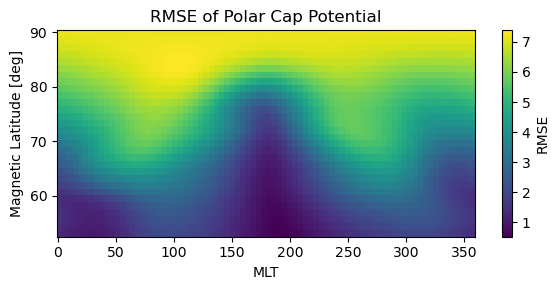

In [71]:
fig = plt.figure(figsize=(6,3))

#plot RMSE as radar plot
cbar = predicted_ds['RMSE'].mean('dt').plot()
plt.title('RMSE of Polar Cap Potential')
plt.ylabel('Magnetic Latitude [deg]')
#plt.xticks(np.arange(0, 25, 3))
plt.xlabel('MLT')

plt.tight_layout()

In [79]:
date = '2022-07-05T00:10:00.000000000'

# Extract true and predicted values
pot_true = predicted_ds['potential'].sel(dt=date).values
pot_pred = predicted_ds['predicted_pot'].sel(dt=date).values

pot_true


array([[  0.26713812,  -0.01870713,  -0.3122021 , ...,   1.068377  ,
          0.8119477 ,   0.54431045],
       [  0.25489092,  -0.05416898,  -0.37164852, ...,   1.1268524 ,
          0.8461862 ,   0.55495334],
       [  0.2497888 ,  -0.08433393,  -0.42851081, ...,   1.1999315 ,
          0.89153725,   0.5739655 ],
       ...,
       [-12.960949  , -13.090139  , -13.216762  , ..., -12.580285  ,
        -12.704873  , -12.832461  ],
       [-13.289404  , -13.357218  , -13.426431  , ..., -13.087655  ,
        -13.153222  , -13.221362  ],
       [-13.518938  , -13.532294  , -13.545857  , ..., -13.480928  ,
        -13.4931755 , -13.505873  ]], dtype=float32)

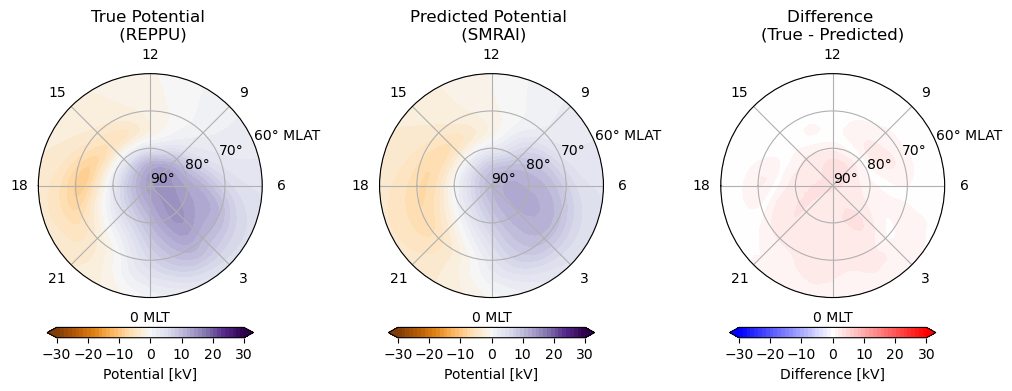

In [84]:
date = '2022-07-05T00:10:00.000000000'

# Extract true and predicted values
pot_true = predicted_ds['potential'].sel(dt=date).values
pot_pred = predicted_ds['predicted_pot'].sel(dt=date).values
rmse  = predicted_ds['RMSE'].sel(dt=date).values

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, rmse, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
#axs[2].set_title('Difference \n(True - Predicted)')
#plt.colorbar(c_diff, ax=axs[2], label='Difference [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

#for RMAE
axs[2].set_title('RMSE')
plt.colorbar(c_diff, ax=axs[2], label='RMSE [kV]', shrink=shrink, pad=0.1, ticks=np.arange(0,31, 10), orientation='horizontal')


plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()